In [2]:
import h5py
import numpy as np
import os 
import statistics
from datetime import datetime
import datetime as datet
import matplotlib.pyplot as plt
from operator import add
import seaborn as sns
import pandas as pd

from scipy.signal import savgol_filter
from matplotlib.ticker import MaxNLocator

import pickle

from typing_extensions import Literal

# Set figure resolution.
plt.rcParams["figure.dpi"] = 150

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
cd "/content/drive/MyDrive/datasets/refit/"

/content/drive/MyDrive/datasets/refit


In [5]:
# Collab does not support protocol5 by def, this is workaround
!pip3 install pickle5
import pickle5 as pickle
with open("EC_UI_demo_res.pkl", "rb") as fh:
  data = pickle.load(fh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.4 MB/s 


In [6]:
fh = open("EC_UI_demo_res.pkl", "rb")
r = pickle.load(fh)

In [7]:
# For UI i would say usefull ones are

# - activation matrix
# - stds (standard deviations for list of good and bad appliances)
# - LP (Load profile could also be presented as a graph)
# - date_norm_test and date_anom_test for checking anomalues 
# - date_norm_train and date_anom_train ?? could be used i gueess

# others are probably not as usefull...

r.columns

Index(['dataset', 'anom_ratio', 'building', 'dyn_n', 'train_percs',
       'test_percs', 'avg_anom_ratio', 'percent_bellow', 'n_days_train',
       'n_days_test', 'app_health_train', 'app_health_test',
       'activation_matrix', 'stds', 'LP', 'date_norm_train', 'date_anom_train',
       'date_norm_test', 'date_anom_test', 'buckets_to_use',
       'param_std_threshold', 'parm_probability_threshold', 'param_time_res',
       'param_LP_time_range', 'param_LP_buckets', 'param_omit_weekends'],
      dtype='object')

In [ ]:
# All values for building 1 with anomales. 
r[r["building"]==3]["date_anom_test"].values[0]

# All values for building 1 with anomales. 
#r[r["building"]==1]["date_norm_test"].values[0]

In [9]:
# Get first date of the test data (train data contains a lot more data!)
first_date = r[r["building"]==1]["date_anom_test"].values[0][0]
last_date = r[r["building"]==1]["date_anom_test"].values[0][-1]
print("first date", first_date)
print("last date", last_date)

first date 2015-03-06 18:00:00
last date 2015-07-09 18:00:00


In [10]:
x = r[r["building"]==1]["date_anom_test"].values[0][2]
print("datum", x)

datum 2015-03-07 18:00:00


In [11]:
# Get all dates in between with hourly freq.
dates = pd.date_range(start=first_date,end=last_date,freq="H")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

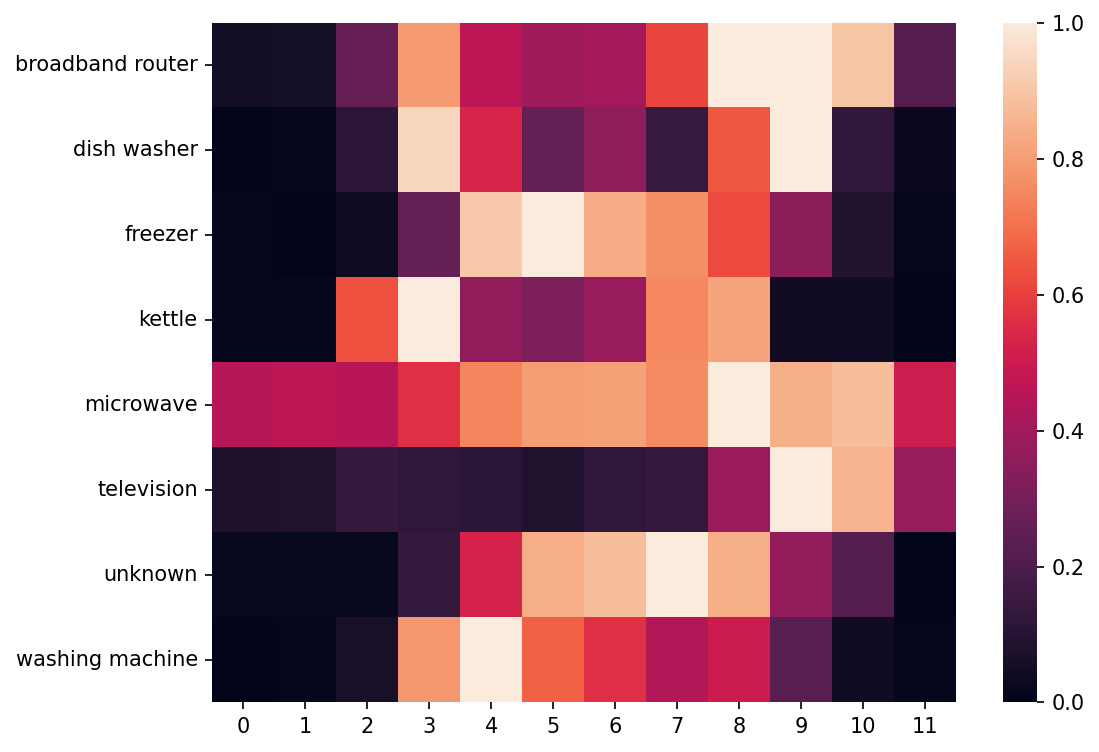

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

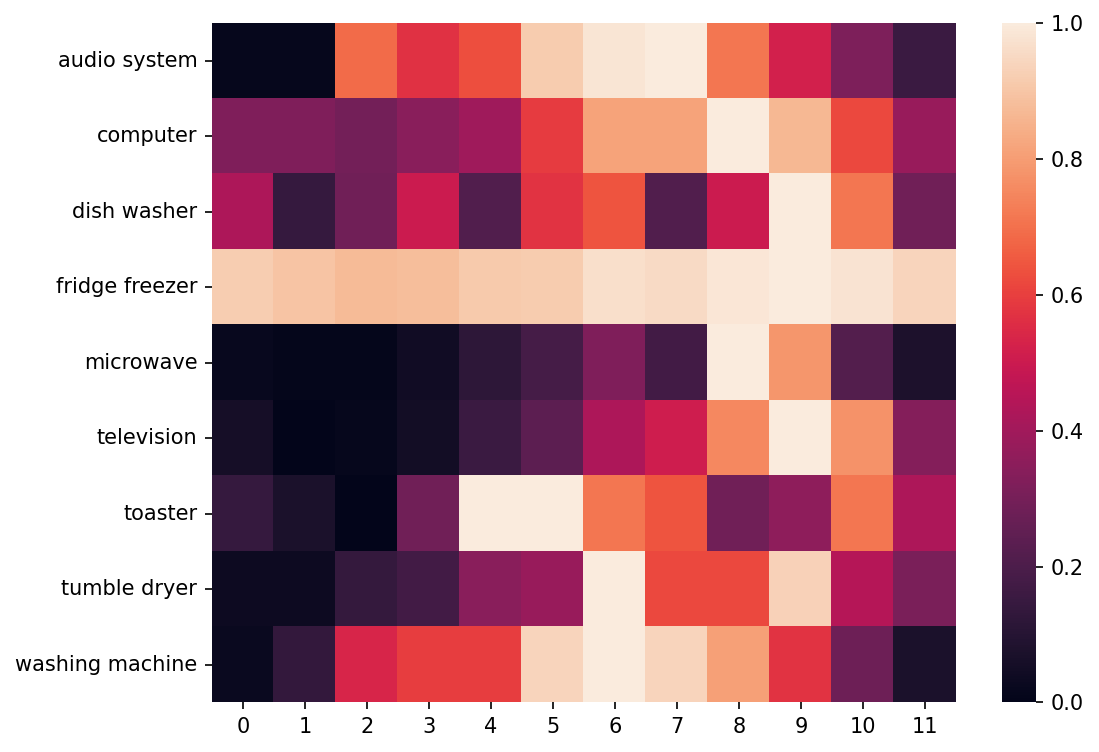

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

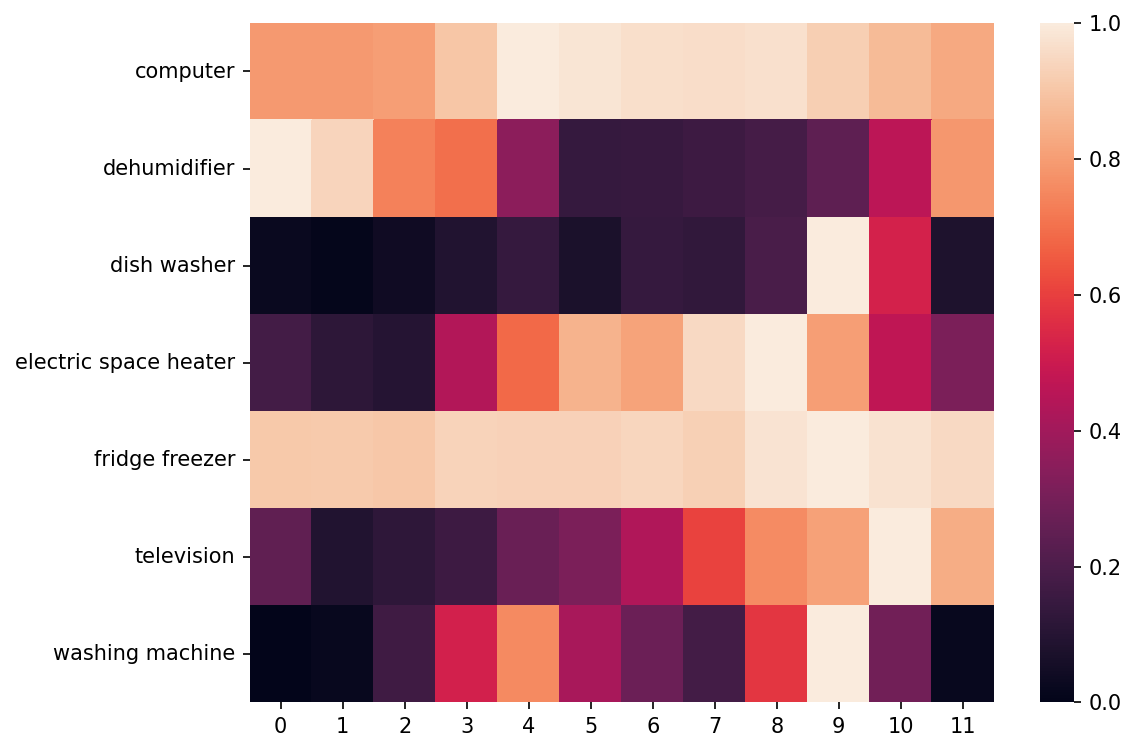

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

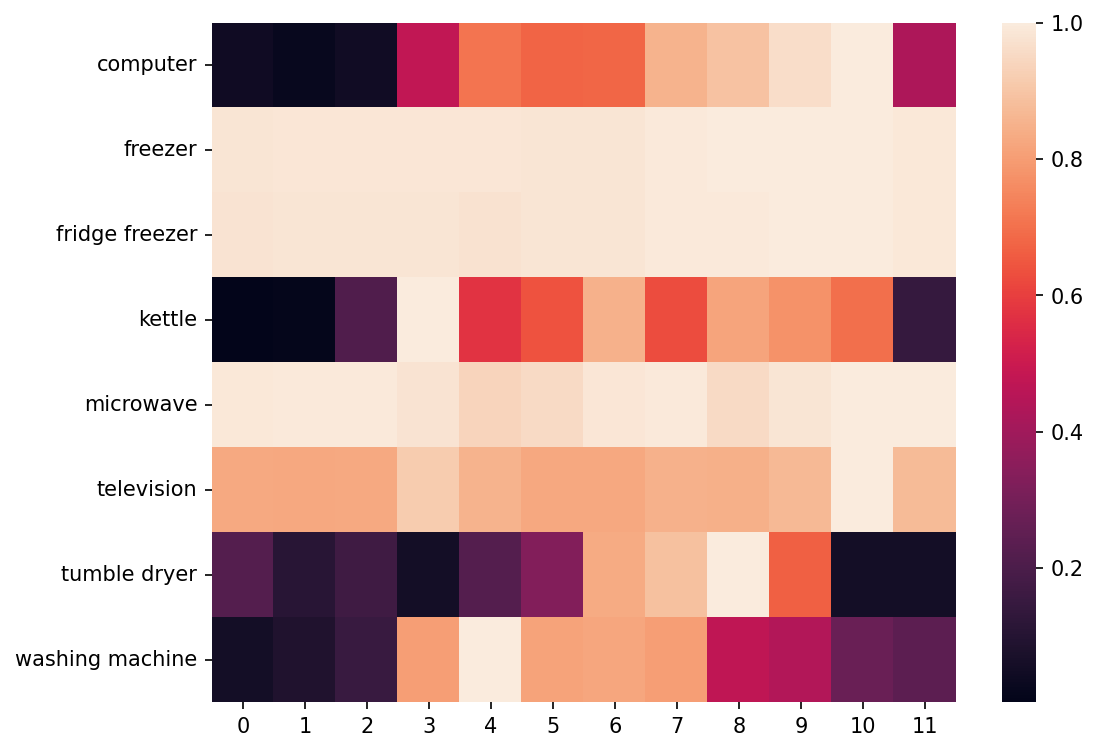

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

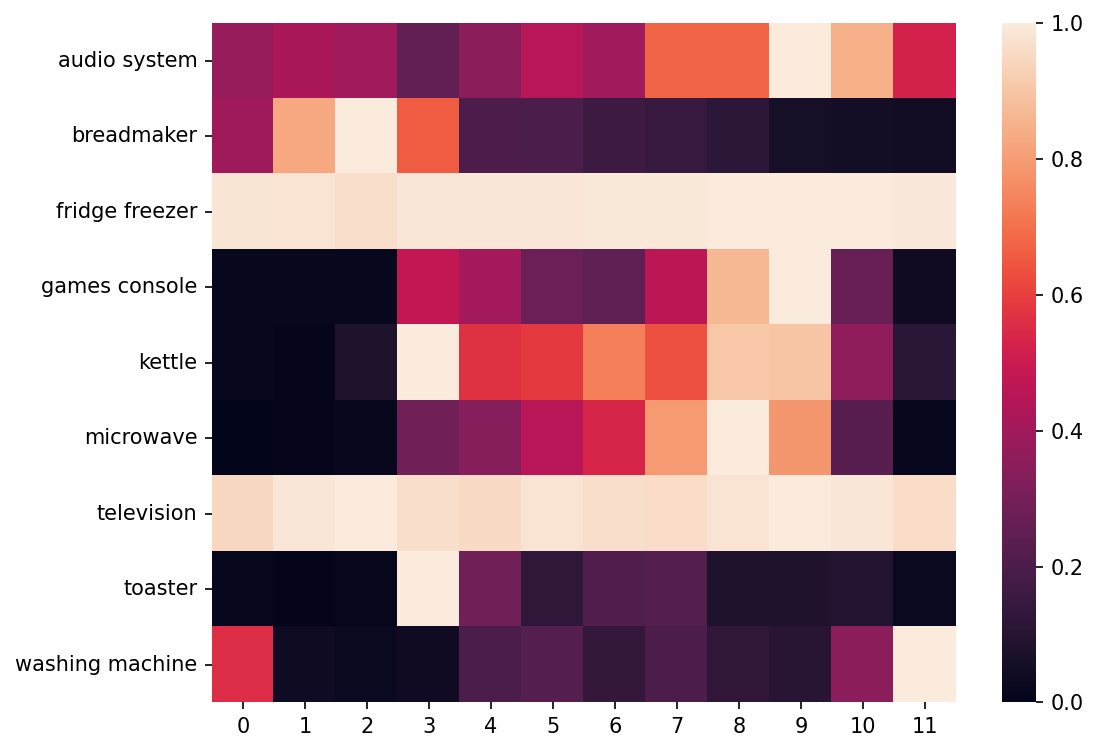

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

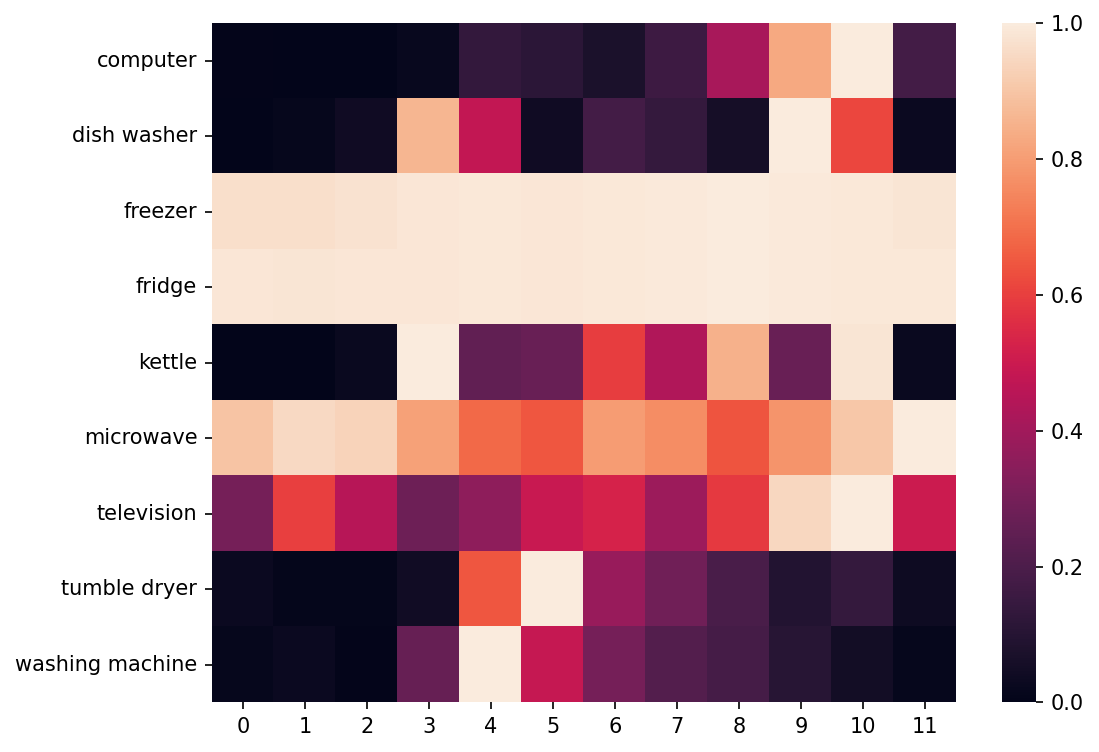

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

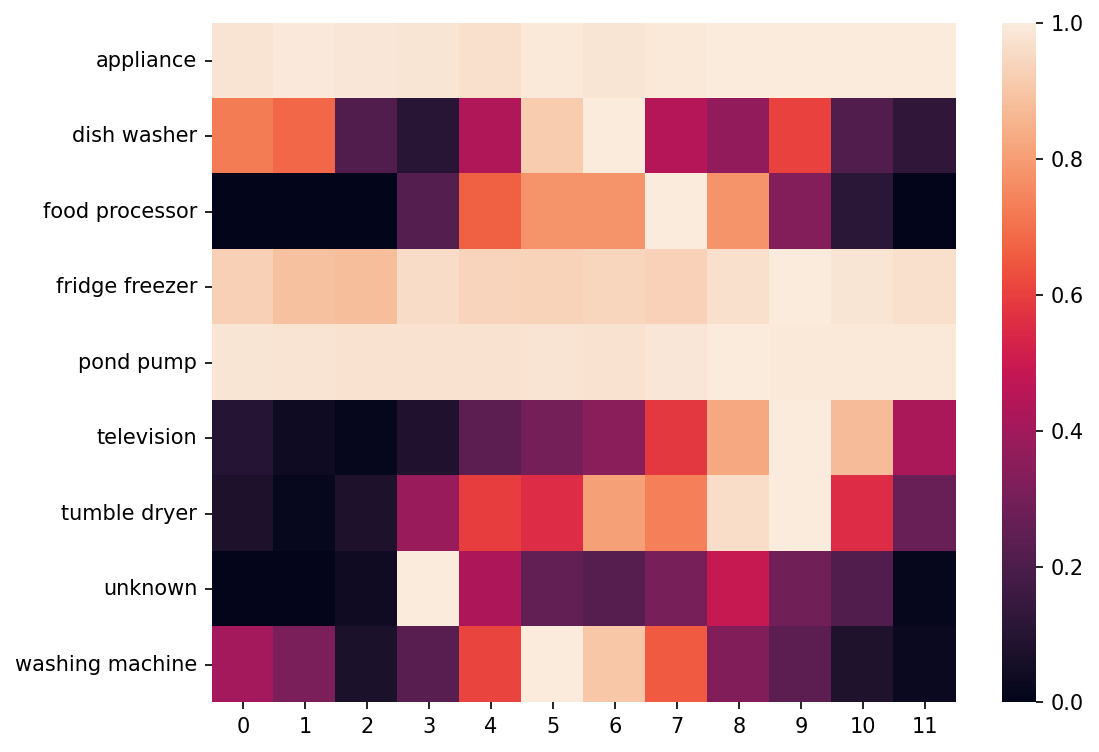

In [83]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#||||||||||||||||||||||||||||||Heatmaps|||||||||||||||||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

from google.colab import files
for i in range(1,12):
  LP = r[r["building"]==i]["LP"].values[0]
  buckets = r[r["building"]==i]["param_LP_buckets"].values[0]
  for appliance, values in LP.items():
    try:
      LP[appliance] = [float(i)/max(values) for i in values]
    except (ZeroDivisionError) as e:
      print("ZeroDiv err")
      activations[appliance]  = [0]*buckets
  hist = [np.array(list(d)) for d in LP.values()]  
  plt.figure(figsize=(8, 6), dpi=150)
  sns.heatmap(hist, yticklabels=list(LP.keys()))
  plt.savefig(f"heatmap{i}.png", bbox_inches='tight')
  files.download(f"heatmap{i}.png")
  plt.pause(0.05)

for i in range(13,17):
  LP = r[r["building"]==i]["LP"].values[0]
  buckets = r[r["building"]==i]["param_LP_buckets"].values[0]
  for appliance, values in LP.items():
    try:
      LP[appliance] = [float(i)/max(values) for i in values]
    except (ZeroDivisionError) as e:
      print("ZeroDiv err")
      activations[appliance]  = [0]*buckets
  hist = [np.array(list(d)) for d in LP.values()]  
  plt.figure(figsize=(8, 6), dpi=150)
  sns.heatmap(hist, yticklabels=list(LP.keys()))
  plt.savefig(f"heatmap{i}.png", bbox_inches='tight')
  files.download(f"heatmap{i}.png")
  plt.pause(0.05)
for i in range(18,21):
  LP = r[r["building"]==i]["LP"].values[0]
  buckets = r[r["building"]==i]["param_LP_buckets"].values[0]
  for appliance, values in LP.items():
    try:
      LP[appliance] = [float(i)/max(values) for i in values]
    except (ZeroDivisionError) as e:
      print("ZeroDiv err")
      activations[appliance]  = [0]*buckets
  hist = [np.array(list(d)) for d in LP.values()]  
  plt.figure(figsize=(8, 6), dpi=150)
  sns.heatmap(hist, yticklabels=list(LP.keys()))
  plt.savefig(f"heatmap{i}.png", bbox_inches='tight')
  files.download(f"heatmap{i}.png")
  plt.pause(0.05)


In [12]:
def calc_perc(anom: list, norm: list) -> float:
    "Function returns percentage ratio between normal and abnormal samples."

    anom = len(anom)
    norm = len(norm)

    return 100*(norm)/(anom+norm)

def filter_dates(data, start_date, end_date):
  "function returns dates betwen start and stop"
  return [d for d in data if d > start_date and d < end_date]

In [13]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#||||||||||||||||||||||||||||||||Routine%Code|||||||||||||||||||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# Parse results from pandas data frame.

all_measurements = []
buildings_check = {
        "refit":[],
        "eco":[],
        "uk-dale":[]
    }

for ds in ["refit"]:  #["eco", "uk-dale", "refit"]:

    print("starting",ds)
    time_res = "days"
    measurements = []
    buildings = []
    count = 0
    lens = []
    tl_from =[]
    tl_to = []

    
    for building in r[r["dataset"]==ds]["building"]:


        print("starting building",building)


        for key, item in r[r["dataset"]==ds][r["building"]==building].iteritems():
            
            # To get train data change to key == "date_norm_train": ---------------------------- ! importat
            if key == "date_norm_test":
                date_norm = item.to_list()[0]

            if key == "date_anom_test":
                date_anom = item.to_list()[0]

        if time_res == "months":
            _,a = (np.unique(np.array([e.month for e in date_anom]), return_counts=True))
            _,n = (np.unique(np.array([e.month for e in date_norm]), return_counts=True))


        elif time_res == "days":
            _,a = (np.unique(np.array([e.weekday() for e in date_anom]), return_counts=True))
            _,n = (np.unique(np.array([e.weekday() for e in date_norm]), return_counts=True))
            x = [ 'Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


        elif time_res == "weeks":
            _,a = (np.unique(np.array([int(e.strftime("%V")) for e in date_anom]), return_counts=True))
            _,n = (np.unique(np.array([int(e.strftime("%V")) for e in date_norm]), return_counts=True))

        elif time_res == "hours":
            _,a = (np.unique(np.array([e.hour for e in date_anom]), return_counts=True))
            _,n = (np.unique(np.array([e.hour for e in date_norm]), return_counts=True))

        else:
            print("Please select suitable time range!")
            
        s = sum(a)+sum(n)
        
        lens.append(s)
        
        time_dist_res = ([100*(b)/(a+b) for (a,b) in zip(a,n)])
        measurements.append(calc_perc(date_anom,date_norm))
        

        print(time_dist_res)
        print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
        buildings.append(building)

    print("done!")

    #if ds in ["uk-dale","eco"]:
    all_measurements+=measurements
    buildings_check[ds] = buildings

measurements = all_measurements

starting refit
starting building 4
[98.36065573770492, 94.91525423728814, 89.70588235294117, 86.66666666666667, 88.73239436619718, 84.28571428571429, 78.78787878787878]
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
starting building 16
[78.46153846153847, 82.05128205128206, 90.625, 98.82352941176471, 90.21739130434783, 84.52380952380952]
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
starting building 7
[82.14285714285714, 73.4375, 91.30434782608695, 76.0, 69.11764705882354, 93.33333333333333, 86.36363636363636]
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
starting building 11
[84.0909090909091, 86.66666666666667, 95.23809523809524, 86.36363636363636, 73.33333333333333, 66.66666666666667, 80.0]
||

In [14]:
# Some buildings have to little data for us to calculate the routine recurrence for the whole week. With this piece of code we find which.

for ds in ["refit"]:  #["eco", "uk-dale", "refit"]:

    print("starting",ds)
    time_res = "days"
    measurements = []
    buildings = []
    count = 0
    lens = []
    tl_from =[]
    tl_to = []
    for building in r[r["dataset"]==ds]["building"]:
        for key, item in r[r["dataset"]==ds][r["building"]==building].iteritems():
            
        # To get train data change to key == "date_norm_train": ---------------------------- ! importat
            if key == "date_anom_test":
                date_anom = item.to_list()[0]

        place,a = (np.unique(np.array([e.isoweekday() for e in date_anom]), return_counts=True))
        if len(place)<7: print(f"We have less data then needed for a whole week in house {building}, that results in days which should be [1,2,3,4,5,6,7] to instead be {place}")

starting refit
We have less data then needed for a whole week in house 16, that results in days which should be [1,2,3,4,5,6,7] to instead be [1 2 4 5 6 7]
We have less data then needed for a whole week in house 14, that results in days which should be [1,2,3,4,5,6,7] to instead be [1 2 3 4 5 6]
We have less data then needed for a whole week in house 13, that results in days which should be [1,2,3,4,5,6,7] to instead be [1 2 4 5 6 7]


In [15]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#|||||||||||||||||||||||NumberOfAnomaliesPerDayGraphCode||||||||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

for ds in ["refit"]:  #["eco", "uk-dale", "refit"]:

    print("starting",ds)
    time_res = "days"
    measurements = []
    buildings = []
    count = 0
    lens = []
    tl_from =[]
    tl_to = []
    for building in r[r["dataset"]==ds]["building"]:
        print("starting building",building)
        for key, item in r[r["dataset"]==ds][r["building"]==building].iteritems():
            
        # To get train data change to key == "date_norm_train": ---------------------------- ! importat
            if key == "date_anom_test":
                date_anom = item.to_list()[0]

        # filter dates that are not in certain range
        start_d=30
        stop_d=37
        start_d = dates[start_d*24+6]
        stop_d = dates[stop_d*24+6]
        date_anom = filter_dates(date_anom, start_d, stop_d)

        # get days of the week where anomaly happened into ac
        # first we get the place/index where the number of anomalies will lie in the table. 
        place,a = (np.unique(np.array([e.weekday() for e in date_anom]), return_counts=True))
        #print(place)

        # then we get the number of anomalies  
        NumberOfAnomalies =[]
        y=0
        for i in range(0,len(date_anom)):
          if y < len(date_anom):
            d_d = date_anom[y].isoweekday()
            count=0
            for j in range(y,len(date_anom)):
              d_dd = date_anom[j].isoweekday()
              if d_d == d_dd:
                count=count+1
            NumberOfAnomalies.append(count)
            y=y+count
        #print(NumberOfAnomalies)

        # then we put the number of anomalies where it belongs
        FinalTable=[0,0,0,0,0,0,0]
        for i in range(0,len(place)):
          FinalTable[place[i]] = NumberOfAnomalies[i]
        print(FinalTable)

starting refit
starting building 4
[0, 0, 1, 1, 1, 1, 1]
starting building 16
[0, 0, 0, 0, 0, 1, 0]
starting building 7
[0, 1, 0, 1, 1, 1, 1]
starting building 11
[0, 0, 0, 0, 0, 0, 0]
starting building 14
[0, 0, 0, 0, 0, 0, 0]
starting building 15
[0, 2, 3, 1, 0, 3, 2]
starting building 1
[0, 0, 0, 0, 0, 1, 0]
starting building 2
[0, 0, 0, 0, 0, 1, 0]
starting building 20
[0, 0, 0, 0, 0, 0, 0]
starting building 6
[0, 4, 0, 2, 0, 0, 0]
starting building 3
[0, 0, 1, 0, 1, 1, 0]
starting building 5
[0, 0, 1, 0, 0, 0, 0]
starting building 10
[0, 2, 2, 0, 2, 2, 0]
starting building 8
[0, 2, 0, 0, 1, 2, 2]
starting building 19
[0, 1, 1, 1, 1, 4, 3]
starting building 9
[0, 3, 3, 0, 1, 1, 0]
starting building 18
[0, 1, 3, 1, 1, 1, 2]
starting building 13
[0, 0, 0, 0, 0, 0, 0]


In [16]:
c = 0
for date in dates[1000:-1]:

  some_date = date
  break

some_date = dates[100]
some_date2 = dates[300]

In [17]:
# Can be a different function for other time ranges 
def get_routine_for_today(r,day,building):
                                          # I guess it must be obtained based on train data
  date_anom = (r[r["building"]==building]["date_anom_train"].values[0])
  date_norm = (r[r["building"]==building]["date_norm_train"].values[0])
    
  _,a = (np.unique(np.array([e.weekday() for e in date_anom]), return_counts=True))
  _,n = (np.unique(np.array([e.weekday() for e in date_norm]), return_counts=True))

  time_dist_res = ([100*(b)/(a+b) for (a,b) in zip(a,n)])
  return time_dist_res[day].round(2)

In [18]:
# returns the date and time and accuracy of prediction, neede for the code below
def last_anomaly_detected(building: int, day: int):
  anoms = (r[r["building"]==building]["date_anom_test"].values[0])
  now = day*24+6
  count=0
  time_past_anoms=[]
  for i in range(0, now):
    if dates[i] in anoms:
      time_past_anoms.append(i)
      count=count+1
  TimeLastAnomaly=time_past_anoms[count-1]
  time=dates[TimeLastAnomaly]
  chance=get_routine_for_today(r,time.weekday(),building)
  return time, chance

In [19]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#|||||||||||||||LastAnomalyDetectedInfoBoxAndPieChart|||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
day=40 #(15.4)
print(last_anomaly_detected(1,day))
print(last_anomaly_detected(2,day))
print(last_anomaly_detected(3,day))
print(last_anomaly_detected(4,day))
print(last_anomaly_detected(5,day))
print(last_anomaly_detected(6,day))
print(last_anomaly_detected(7,day))
print(last_anomaly_detected(8,day))
print(last_anomaly_detected(9,day))
print(last_anomaly_detected(10,day))
print(last_anomaly_detected(11,day))
print(last_anomaly_detected(13,day))
print(last_anomaly_detected(14,day))
print(last_anomaly_detected(15,day))
print(last_anomaly_detected(16,day))
print(last_anomaly_detected(18,day))
print(last_anomaly_detected(19,day))
print(last_anomaly_detected(20,day))

(Timestamp('2015-04-11 18:00:00', freq='H'), 58.33)
(Timestamp('2015-04-11 14:00:00', freq='H'), 69.29)
(Timestamp('2015-04-15 08:00:00', freq='H'), 79.23)
(Timestamp('2015-04-15 16:00:00', freq='H'), 82.93)
(Timestamp('2015-04-08 04:00:00', freq='H'), 84.33)
(Timestamp('2015-04-13 16:00:00', freq='H'), 97.6)
(Timestamp('2015-04-14 16:00:00', freq='H'), 81.76)
(Timestamp('2015-04-13 10:00:00', freq='H'), 85.33)
(Timestamp('2015-04-14 16:00:00', freq='H'), 74.78)
(Timestamp('2015-04-15 18:00:00', freq='H'), 82.26)
(Timestamp('2015-04-15 20:00:00', freq='H'), 78.2)
(Timestamp('2015-03-10 06:00:00', freq='H'), 95.53)
(Timestamp('2015-04-15 20:00:00', freq='H'), 91.95)
(Timestamp('2015-04-15 14:00:00', freq='H'), 86.64)
(Timestamp('2015-04-14 18:00:00', freq='H'), 81.19)
(Timestamp('2015-04-14 16:00:00', freq='H'), 82.69)
(Timestamp('2015-04-15 10:00:00', freq='H'), 93.59)
(Timestamp('2015-04-15 18:00:00', freq='H'), 77.78)


In [20]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#|||||||||||||||||||||||RoutineImprovementAdvicePart||||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
for i in range(1,12):
  print(i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  print("best 3",srt[-4:-1])  
  print("worst 3",srt[:3])
  print("---------------------------------------------------------------------------------------------------------------")
for i in range(13,17):
  print(i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  print("best 3",srt[-4:-1])  
  print("worst 3",srt[:3])
  print("---------------------------------------------------------------------------------------------------------------")
for i in range(18,21):
  print(i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  print("best 3",srt[-4:-1])  
  print("worst 3",srt[:3])
  print("---------------------------------------------------------------------------------------------------------------")  

1
best 3 [('television', 0.31022284150978136), ('computer', 0.31797472735977506), ('washing machine', 0.32359836116461177)]
worst 3 [('freezer', 0.004686189656407015), ('fridge', 0.046197303640893445), ('washer dryer', 0.24612218853090592)]
---------------------------------------------------------------------------------------------------------------
2
best 3 [('television', 0.3106948557254241), ('kettle', 0.3312825460412911), ('microwave', 0.3315762205490248)]
worst 3 [('fridge freezer', 0.03135593175843758), ('audio system', 0.19580159001851083), ('fan', 0.26944959099695465)]
---------------------------------------------------------------------------------------------------------------
3
best 3 [('kettle', 0.3076873844969109), ('toaster', 0.3308511910084167), ('television', 0.33886328394748483)]
worst 3 [('freezer', 0.0112036676582838), ('fridge freezer', 0.028570406703842383), ('microwave', 0.2824666945964452)]
------------------------------------------------------------------------

In [78]:
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
#|||||||||||InterpratesDiviationAndWritesCodeThatCanBeCopyPastedIntoTheApp||||||||||||||||||
#|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
for i in range(1,12):
  print("building: ", i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  good_bad=[]
  for h in range(0,3):
    if srt[-4:-1][h][1]>0.35:
      good_bad.append("excellent")
    elif srt[-4:-1][h][1]>0.32:
      good_bad.append("very good")
    elif srt[-4:-1][h][1]>0.29:
      good_bad.append("good")
    elif srt[-4:-1][h][1]>0.25:
      good_bad.append("quite good")
    elif srt[-4:-1][h][1]>0.2:
      good_bad.append("decent")
    elif srt[-4:-1][h][1]>0.15:
      good_bad.append("usable")
    elif srt[-4:-1][h][1]>0.1:
      good_bad.append("almost usable")
    else:
      good_bad.append("useless")

  best_table=[]
  for u in range(0,3):
    best_table.append(good_bad[2-u])
  best_names=[]
  for x in range(0,3):
    best_names.append(srt[-4:-1][2-x][0])
  #print(best_names)
  #print(best_table)
  bad=[]
  for h in range(0,3):
    if srt[:3][h][1]>0.35:
      bad.append("excellent")
    elif srt[:3][h][1]>0.32:
      bad.append("very good")
    elif srt[:3][h][1]>0.29:
      bad.append("good")
    elif srt[:3][h][1]>0.25:
      bad.append("quite good")
    elif srt[:3][h][1]>0.2:
      bad.append("decent")
    elif srt[:3][h][1]>0.15:
      bad.append("usable")
    elif srt[:3][h][1]>0.1:
      bad.append("almost usable")
    else:
      bad.append("useless")
  worst_names=[]
  for x in range(0,3):
    worst_names.append(srt[:3][2-x][0])
  worst_table=[]
  for u in range(0,3):
    worst_table.append(bad[2-u])
  #print(worst_names)
  #print(worst_table)
  #print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print("    column2.subheader('Best 3:')")
  for y in range(0,3):
    print(f"    column2.metric(label='{best_names[y]}', value='{best_table[y]}')")
  print("    column2.subheader('Worst 3:')")
  for z in range(0,3):
    print(f"    column2.metric(label='{worst_names[z]}', value='{worst_table[z]}')")
for i in range(13,17):
  print("building: ", i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  good_bad=[]
  for h in range(0,3):
    if srt[-4:-1][h][1]>0.35:
      good_bad.append("excellent")
    elif srt[-4:-1][h][1]>0.32:
      good_bad.append("very good")
    elif srt[-4:-1][h][1]>0.29:
      good_bad.append("good")
    elif srt[-4:-1][h][1]>0.25:
      good_bad.append("quite good")
    elif srt[-4:-1][h][1]>0.2:
      good_bad.append("decent")
    elif srt[-4:-1][h][1]>0.15:
      good_bad.append("usable")
    elif srt[-4:-1][h][1]>0.1:
      good_bad.append("almost usable")
    else:
      good_bad.append("useless")

  best_table=[]
  for u in range(0,3):
    best_table.append(good_bad[2-u])
  best_names=[]
  for x in range(0,3):
    best_names.append(srt[-4:-1][2-x][0])
  #print(best_names)
  #print(best_table)
  bad=[]
  for h in range(0,3):
    if srt[:3][h][1]>0.35:
      bad.append("excellent")
    elif srt[:3][h][1]>0.32:
      bad.append("very good")
    elif srt[:3][h][1]>0.29:
      bad.append("good")
    elif srt[:3][h][1]>0.25:
      bad.append("quite good")
    elif srt[:3][h][1]>0.2:
      bad.append("decent")
    elif srt[:3][h][1]>0.15:
      bad.append("usable")
    elif srt[:3][h][1]>0.1:
      bad.append("almost usable")
    else:
      bad.append("useless")
  worst_names=[]
  for x in range(0,3):
    worst_names.append(srt[:3][2-x][0])
  worst_table=[]
  for u in range(0,3):
    worst_table.append(bad[2-u])
  #print(worst_names)
  #print(worst_table)
  #print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print("    column2.subheader('Best 3:')")
  for y in range(0,3):
    print(f"    column2.metric(label='{best_names[y]}', value='{best_table[y]}')")
  print("    column2.subheader('Worst 3:')")
  for z in range(0,3):
    print(f"    column2.metric(label='{worst_names[z]}', value='{worst_table[z]}')")
for i in range(18,21):
  print("building: ", i)
  stds = (r[r["building"]==i]["stds"].values[0])
  srt = sorted(stds.items(), key=lambda item: item[1])
  good_bad=[]
  for h in range(0,3):
    if srt[-4:-1][h][1]>0.35:
      good_bad.append("excellent")
    elif srt[-4:-1][h][1]>0.32:
      good_bad.append("very good")
    elif srt[-4:-1][h][1]>0.29:
      good_bad.append("good")
    elif srt[-4:-1][h][1]>0.25:
      good_bad.append("quite good")
    elif srt[-4:-1][h][1]>0.2:
      good_bad.append("decent")
    elif srt[-4:-1][h][1]>0.15:
      good_bad.append("usable")
    elif srt[-4:-1][h][1]>0.1:
      good_bad.append("almost usable")
    else:
      good_bad.append("useless")

  best_table=[]
  for u in range(0,3):
    best_table.append(good_bad[2-u])
  best_names=[]
  for x in range(0,3):
    best_names.append(srt[-4:-1][2-x][0])
  #print(best_names)
  #print(best_table)
  bad=[]
  for h in range(0,3):
    if srt[:3][h][1]>0.35:
      bad.append("excellent")
    elif srt[:3][h][1]>0.32:
      bad.append("very good")
    elif srt[:3][h][1]>0.29:
      bad.append("good")
    elif srt[:3][h][1]>0.25:
      bad.append("quite good")
    elif srt[:3][h][1]>0.2:
      bad.append("decent")
    elif srt[:3][h][1]>0.15:
      bad.append("usable")
    elif srt[:3][h][1]>0.1:
      bad.append("almost usable")
    else:
      bad.append("useless")
  worst_names=[]
  for x in range(0,3):
    worst_names.append(srt[:3][2-x][0])
  worst_table=[]
  for u in range(0,3):
    worst_table.append(bad[2-u])
  #print(worst_names)
  #print(worst_table)
  #print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print("    column2.subheader('Best 3:')")
  for y in range(0,3):
    print(f"    column2.metric(label='{best_names[y]}', value='{best_table[y]}')")
  print("    column2.subheader('Worst 3:')")
  for z in range(0,3):
    print(f"    column2.metric(label='{worst_names[z]}', value='{worst_table[z]}')")

building:  1
    column2.subheader('Best 3:')
    column2.metric(label='washing machine', value='very good')
    column2.metric(label='computer', value='good')
    column2.metric(label='television', value='good')
    column2.subheader('Worst 3:')
    column2.metric(label='washer dryer', value='decent')
    column2.metric(label='fridge', value='useless')
    column2.metric(label='freezer', value='useless')
building:  2
    column2.subheader('Best 3:')
    column2.metric(label='microwave', value='very good')
    column2.metric(label='kettle', value='very good')
    column2.metric(label='television', value='good')
    column2.subheader('Worst 3:')
    column2.metric(label='fan', value='quite good')
    column2.metric(label='audio system', value='usable')
    column2.metric(label='fridge freezer', value='useless')
building:  3
    column2.subheader('Best 3:')
    column2.metric(label='television', value='very good')
    column2.metric(label='toaster', value='very good')
    column2.metric(